===Portfolio: Vanguard Canadian===
From 2019-06-19 00:00:00 to 2020-07-19 00:00:00

Initial Investment         = $100,000.00
        Holding     Shares        BookValue      %
        VGRO.TO       3107       80,000.00$  80.0%
        XGRO.TO        489       10,000.00$  10.0%
        VEQT.TO        369       10,000.00$  10.0%

Total Portfolio            = $104,174.46 =  +4,174.46$ =  +4.17% (total) =  +3.79% (annualized)
        Holding     Shares            Value      %
        VGRO.TO       3107       83,168.93$  79.8%
        XGRO.TO        489       10,518.08$  10.1%
        VEQT.TO        369       10,487.44$  10.1%

Total Portfolio Rebalanced = $104,174.46 =  +4,174.46$ =  +4.17% (total) =  +3.79% (annualized)
        Holding     Shares            Value      %
        VGRO.TO       3107       83,168.93$  79.8%
        XGRO.TO        489       10,518.08$  10.1%
        VEQT.TO        369       10,487.44$  10.1%

Total S&P 500 Benchmark    = $109,295.84 =  +9,295.84$ =  +9.30% (to

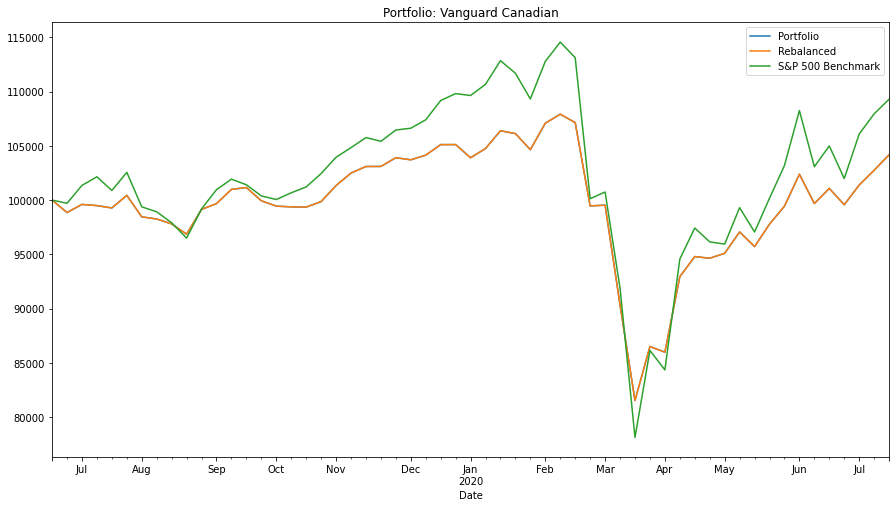




===Portfolio: Tech Stocks===
From 2019-06-19 00:00:00 to 2020-07-19 00:00:00

Initial Investment         = $100,000.00
        Holding     Shares        BookValue      %
           AAPL        402       20,000.00$  20.0%
           AMZN         10       20,000.00$  20.0%
           NFLX         54       20,000.00$  20.0%
             FB        105       20,000.00$  20.0%
          BRK-B         97       20,000.00$  20.0%

Total Portfolio            = $140,293.32 = +40,293.32$ = +40.29% (total) = +31.76% (annualized)
        Holding     Shares            Value      %
           AAPL        402       38,767.48$  27.6%
           AMZN         10       30,994.30$  22.1%
           NFLX         54       26,705.13$  19.0%
             FB        105       25,324.89$  18.1%
          BRK-B         97       18,501.53$  13.2%

Total Portfolio Rebalanced = $140,293.32 = +40,293.32$ = +40.29% (total) = +31.76% (annualized)
        Holding     Shares            Value      %
           AAPL      

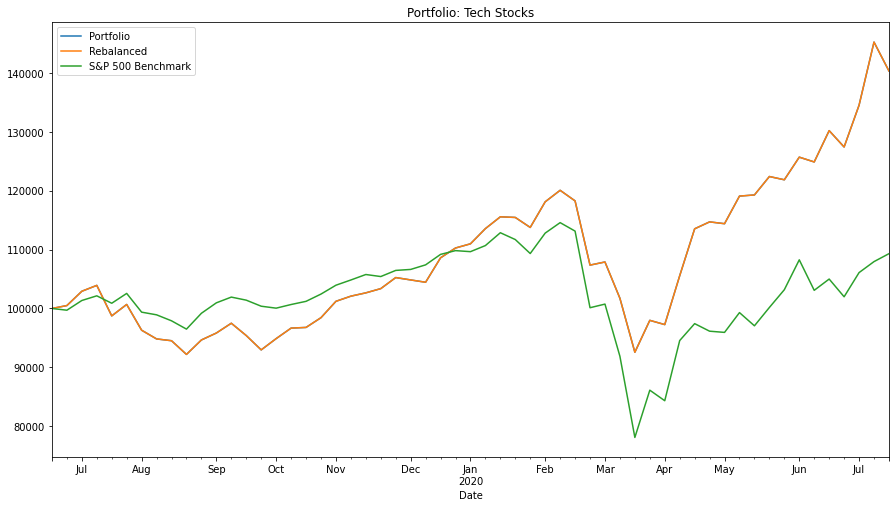




===Portfolio: Tech Stocks===
From 2019-06-19 00:00:00 to 2020-07-19 00:00:00

Initial Investment         = $100,000.00
        Holding     Shares        BookValue      %
            QQQ        530      100,000.00$ 100.0%

Total Portfolio            = $137,572.26 = +37,572.26$ = +37.57% (total) = +29.90% (annualized)
        Holding     Shares            Value      %
            QQQ        530      137,572.26$ 100.0%

Total Portfolio Rebalanced = $137,572.26 = +37,572.26$ = +37.57% (total) = +29.90% (annualized)
        Holding     Shares            Value      %
            QQQ        530      137,572.26$ 100.0%

Total S&P 500 Benchmark    = $109,295.84 =  +9,295.84$ =  +9.30% (total) =  +8.26% (annualized)




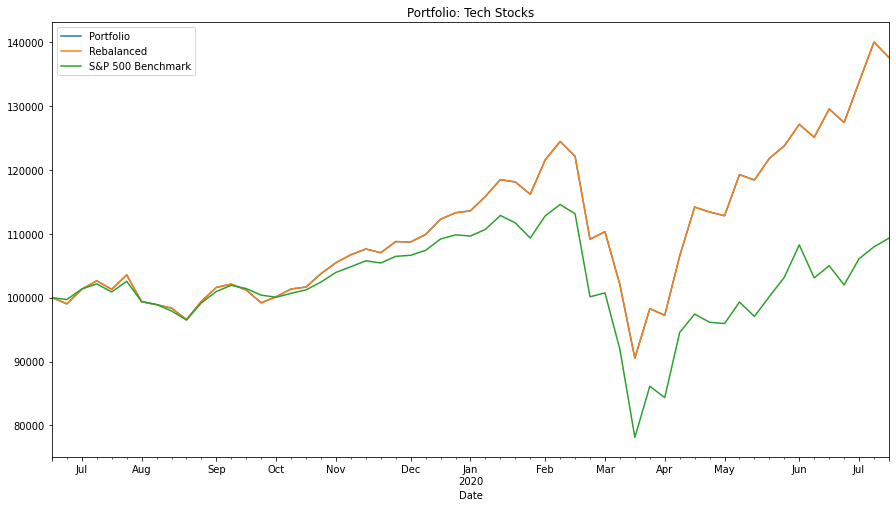

In [1]:
%config IPCompleter.greedy=True
#import backtest
from backtest import Holding, download_portfolio_history, rebalance_portfolio, plot_results
import datetime


# Dollars initially invested
initial_investment = 100000
# USD to CAD exchange rate
usd_cad = 1.3

# Collect data for this time period
start = datetime.datetime(2019,  6, 19)
end   = datetime.datetime(2020,  7, 19)


# Baseline benchmark
benchmark_portfolio = {
    'name': 'S&P 500 Benchmark',
    'holdings': [Holding('^GSPC', 100, 'S&P 500')]
}
benchmark_data, benchmark_num_shares = download_portfolio_history(benchmark_portfolio, start, end, initial_investment, usd_cad)


# Portfolio: Ticker, percentage of holdings, description
portfolios = [
    {
        'name': 'Vanguard Canadian',
        'holdings': [
            Holding('VGRO.TO', 80, 'Vanguard Growth ETF Portfolio (CAD)'),
            Holding('XGRO.TO', 10, 'iShares Core Growth ETF Portfolio (CAD)'),
            Holding('VEQT.TO', 10, 'Vanguard All-Equity ETF Portfolio (CAD)'),
        ]
    },
    {
        'name': 'Tech Stocks',
        'holdings': [
            Holding('AAPL', 20, ''),
            Holding('AMZN', 20, ''),
            Holding('NFLX', 20, ''),
            Holding('FB',   20, ''),
            Holding('BRK-B', 20, '')]
    },
    {
        'name': 'Tech Stocks',
        'holdings': [
            Holding('QQQ', 100, ''),
        ]
    },
]

for portfolio in portfolios:
    portfolio_data, portfolio_num_shares = download_portfolio_history(portfolio, start, end, initial_investment, usd_cad)
    rebalanced_num_shares = rebalance_portfolio(portfolio, portfolio_data, portfolio_num_shares, start, end)

    plot_results(portfolio, portfolio_data, portfolio_num_shares, rebalanced_num_shares, benchmark_portfolio, benchmark_data, benchmark_num_shares, start, end, initial_investment)
